Propmpt: You’re on the data science team at Honda. Your team is trying to understand regional automotive demand in the United States, as you plan your manufacturing goals. 

●	Through some limited market research we’ve discovered a strong regional demand for Honda in Omaha, NE. We’d like to know what other regional markets have similar demand:  .

●	What are some promising markets for Honda to expand to? What makes it promising? How do we know that we’re not over saturating the market or expanding into a hostile market?

●	Are there any other interesting insights or trends that are actionable?

You can find the data here:
[craigslistvehicles.csv](https://drive.google.com/file/d/1w_IO5nhPJq7Ld2WJNBh4EcvM7LYY58w5/view?usp=sharing) <- 1GB
[craigslistvehiclesFull.csv](https://drive.google.com/file/d/1UB6elnAz-REdX3RfO6x_I_3waPa6QuCI/view?usp=sharing) <- 0.5 GB

Note: The final two cells produce large graphs, so those outputs have not been saved in advance for file size reasons - you will have to run these cells yourself

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import folium
from folium.plugins import HeatMap
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

In [7]:
df1 = pd.read_csv('craigslistVehicles.csv', delimiter=',')
df1.dataframeName = 'craigslistVehicles.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

df2 = pd.read_csv('craigslistVehiclesFull.csv', delimiter=',')
df2.dataframeName = 'craigslistVehiclesFull.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 443405 rows and 22 columns
There are 1723065 rows and 26 columns


notes:
* can probably toss out url, city_url, VIN, image_url
* price, year, odometer, lat, long are numeric
* city and manufacturer are string
* make is a very varied string
* condition, fuel, title_status, transmission, drive, size, type, paint_color is categorical
* cylinders can be numeric if you strip it
* desc is a very long string - can use NLP?
* "full" is missing "desc" but includes county_fips, county_name, state_fips, state_code, state_name, weather
* does "full" contain duplicates?

In [8]:
df = df1.append(df2)
df = df.replace('chevy', 'chevrolet')
df = df.replace('chev', 'chevrolet')
df = df.replace('infinity', 'infiniti')
df = df.replace('mercedesbenz', 'mercedes-benz')
df['cylinders'] = df['cylinders'].str.rstrip('cylinders')
idx_str = ['price', 'year', 'odometer', 'lat', 'long','cylinders'] 
for label in idx_str:
    df[label] = df[label].apply(pd.to_numeric, errors='coerce')

In [9]:
df = df.sort_values(by=['manufacturer'])
df = df.sort_values(by=['type'])

In [10]:
omaha_df = df[df["city"]=="omaha"]
honda_df = df[df["manufacturer"]=="honda"]
omahonda_df = honda_df[honda_df["city"]=="omaha"]

In [11]:
honda_df['omaha_indicator'] = honda_df['city'].apply(lambda x : x == 'omaha')
omaha_df['honda_indicator'] = omaha_df['manufacturer'].apply(lambda x : x == 'honda')

In [12]:
honda_df['omaha_distance'] = np.sqrt((honda_df['lat']-41.2565)**2 + (honda_df['long']+95.9345)**2)

In [13]:
honda_train = honda_df.drop(['url',
 'city',
 'city_url','manufacturer','make','VIN','image_url',
 'desc','lat',
 'long','vin',
 'county_fips',
 'county_name',
 'state_fips',
 'state_code',
 'state_name','weather','omaha_indicator','omaha_distance'], axis=1)

In [14]:
omaha_train = omaha_df.drop(['url',
 'city',
 'city_url','manufacturer','make','VIN','image_url',
 'desc','vin',
 'county_fips',
 'county_name',
 'state_fips',
 'state_code',
 'state_name', 'honda_indicator','lat','long','weather'], axis=1)

In [105]:
honda_x = pd.get_dummies(honda_train)
omaha_x = pd.get_dummies(omaha_train)

In [11]:
#binomial logistic regression model
#the following modeling technique is based on 
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

#more libraries
import imblearn

#SMOTE (Synthetic Minority Oversampling Technique) is a method to improve model training when one category (ie converted)
#has many more instances than another category (ie unconverted) by generating realistic additional training data
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

In [106]:
#train_test_split splits arrays or matrices into random train and test subsets
omaha_x = omaha_x.fillna(0)
X = omaha_x
y = omaha_df['honda_indicator']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [107]:
#os.fit_sample implements SMOTE and resamples the dataset
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['honda_indicator'])

In [108]:
#time to find out how good the model is. this code fits a classifier to the data
#the classifier is the same as the above model i think?

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, \
                   intercept_scaling = 1, max_iter = 100, multi_class = 'ovr', n_jobs= 1, \
                   penalty='l2', random_state = None, solver = 'liblinear' , tol = 0.0001, verbose=0, warm_start=False)

#the point is that the model performs very well

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.61


C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



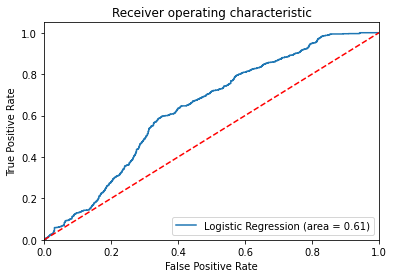

In [109]:
#ROC curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [110]:
importances = pd.DataFrame({'num':abs(np.squeeze(logreg.coef_))})
importances['dir'] = np.sign(np.squeeze(logreg.coef_))
importances['name'] = list(X_train)
importances['first'] = importances['name'].str.split('_').str[0]
importances['std'] = np.std(X_train).values
importances['norm'] = importances['num']*importances['std']
importances_g = importances.groupby(by=['first']).sum() 
#print(np.std(X_train, 0)*logreg.coef_)
# summarize feature importance
#for i in range(len(importance)):
#    print('Feature: ', names[i], ', Score: ', importance[i])
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

In [111]:
importances

,num,dir,name,first,std,norm
0,8.209621e-05,-1.0,price,price,8699.160620,7.141681e-01
1,4.061361e-04,1.0,year,year,52.514020,2.132784e-02
2,3.037395e-07,1.0,cylinders,cylinders,2.651848,8.054711e-07
3,3.940165e-07,-1.0,odometer,odometer,153021.458642,6.029299e-02
4,2.121605e-08,-1.0,condition_excellent,condition,0.440892,9.353987e-09
5,2.666652e-08,-1.0,condition_fair,condition,0.116976,3.119356e-09
6,1.377213e-07,-1.0,condition_good,condition,0.334446,4.606037e-08
7,2.694527e-08,-1.0,condition_like new,condition,0.170584,4.596420e-09
8,9.284642e-10,-1.0,condition_new,condition,0.025697,2.385859e-11
9,2.553282e-09,-1.0,condition_salvage,condition,0.038099,9.727861e-11


In [112]:
importances_g

,num,dir,std,norm
first,,,,
condition,2.160309e-07,-6.0,1.126695,6.325127e-08
cylinders,3.037395e-07,1.0,2.651848,8.054711e-07
drive,5.447591e-07,-1.0,1.074901,2.102123e-07
fuel,3.270431e-07,-3.0,0.607756,7.752104e-08
odometer,3.940165e-07,-1.0,153021.458642,6.029299e-02
paint,3.863807e-07,-12.0,1.798017,8.754989e-08
price,8.209621e-05,-1.0,8699.160620,7.141681e-01
size,2.486920e-07,-2.0,0.775686,7.065159e-08
title,6.866080e-08,-4.0,0.863925,1.059778e-08


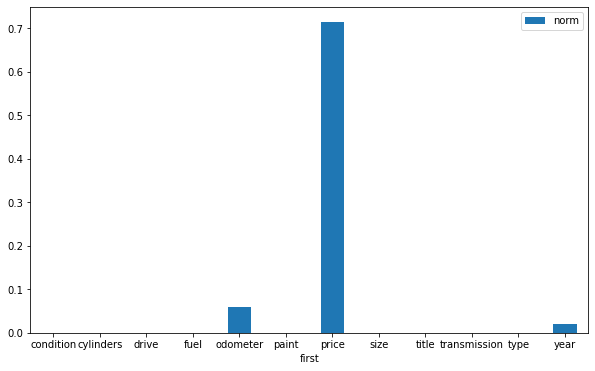

In [114]:
ax = importances_g.plot.bar(y='norm', rot=0,figsize=(10,6))

In [65]:
#train_test_split splits arrays or matrices into random train and test subsets
honda_x = honda_x.fillna(0)
X = honda_x
y = honda_df['omaha_indicator']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [66]:
#os.fit_sample implements SMOTE and resamples the dataset
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['omaha_indicator'])

In [69]:
#time to find out how good the model is. this code fits a classifier to the data
#the classifier is the same as the above model i think?

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True, \
                   intercept_scaling = 1, max_iter = 100, multi_class = 'ovr', n_jobs= 1, \
                   penalty='l2', random_state = None, solver = 'liblinear' , tol = 0.0001, verbose=0, warm_start=False)

#the point is that the model performs very well

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Accuracy of logistic regression classifier on test set: 0.60


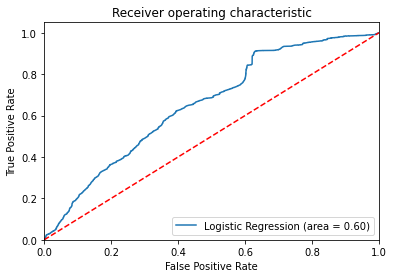

In [70]:
#ROC curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [76]:
h_importances = pd.DataFrame({'num':abs(np.squeeze(logreg.coef_))})
h_importances['dir'] = np.sign(np.squeeze(logreg.coef_))
h_importances['name'] = list(X_train)
h_importances['first'] = importances['name'].str.split('_').str[0]
h_importances['std'] = np.std(X_train).values
h_importances['norm'] = importances['num']*importances['std']
h_importances_g = importances.groupby(by=['first']).sum() 
#print(np.std(X_train, 0)*logreg.coef_)
# summarize feature importance
#for i in range(len(importance)):
#    print('Feature: ', names[i], ', Score: ', importance[i])
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

In [75]:
import pickle

filename = 'magic_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [77]:
h_importances

,num,dir,name,first,std,norm
0,2.064247e-07,-1.0,price,price,38119.726809,7.868853e-03
1,2.472099e-04,-1.0,year,year,81.427886,2.012978e-02
2,2.446300e-01,1.0,cylinders,cylinders,2.232244,5.460738e-01
3,2.160766e-06,-1.0,odometer,odometer,97339.423113,2.103277e-01
4,7.015054e-03,-1.0,condition_excellent,condition,0.432070,3.030995e-03
5,1.133249e-02,-1.0,condition_fair,condition,0.138938,1.574519e-03
6,4.682081e-02,-1.0,condition_good,condition,0.346624,1.622923e-02
7,1.628265e-02,-1.0,condition_like new,condition,0.185408,3.018936e-03
8,1.047486e-03,-1.0,condition_new,condition,0.041721,4.370197e-05
9,1.230886e-03,-1.0,condition_salvage,condition,0.045752,5.631549e-05


In [78]:
h_importances_g

,num,dir,std,norm
first,,,,
condition,8.372938e-02,-6.0,1.190514,0.023954
cylinders,2.446300e-01,1.0,2.232244,0.546074
drive,5.704409e-02,-3.0,0.849080,0.021223
fuel,1.590557e-02,-3.0,0.421317,0.001958
odometer,2.160766e-06,-1.0,97339.423113,0.210328
paint,1.419650e-01,-12.0,1.743791,0.030001
price,2.064247e-07,-1.0,38119.726809,0.007869
size,8.663052e-02,-4.0,0.820860,0.020483
title,8.177464e-02,-6.0,0.832989,0.026976


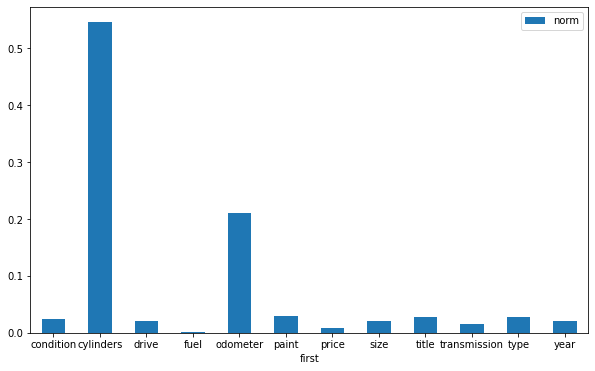

In [82]:
ax = h_importances_g.plot.bar(y='norm', rot=0,figsize=(10,6))

In [30]:
oLabels = df[df["city"]=="omaha"].manufacturer.value_counts().index
oValues = df[df["city"]=="omaha"].manufacturer.value_counts().values
all_labels = df.manufacturer.value_counts().index
all_Values = df.manufacturer.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],subplot_titles=("All cities", "Omaha"))
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 1)
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.show()

insights: ford and chevy have market dominance in this data, more so in omaha. dodge is disproportionately popular in omaha (maybe an american made preference). toyota is outcompeting honda both in general and in omaha, but nissan is outcompeting only in omaha. there is a weird lack of bmws and volkswagens in omaha.

notes: sedans and pickups popular in omaha, trucks less popular

takeaways: the most popular honda vehicles are sedans and suvs, some coupes and minivans.

questions:
* do they prefer american brands in omaha?
* in which cities do they disproportionately prefer honda? disprefer honda?

notes on data to merge:
* chevrolet, chevy, chev
* mercedes benz, mercedesbenz

In [31]:
oLabels = df[df["city"]=="omaha"].type.value_counts().index
oValues = df[df["city"]=="omaha"].type.value_counts().values
hLabels = df[df["manufacturer"]=="honda"].type.value_counts().index
hValues = df[df["manufacturer"]=="honda"].type.value_counts().values
oh_labels = omahonda_df.type.value_counts().index
oh_Values = omahonda_df.type.value_counts().values
all_labels = df.type.value_counts().index
all_Values = df.type.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=800, width=1000,
                  title_text="Vehicle type")

fig.show()

condition, fuel, title_status, transmission, drive, size, type, paint_color is categorical

In [17]:
oLabels = df[df["city"]=="omaha"].condition.value_counts().index
oValues = df[df["city"]=="omaha"].condition.value_counts().values
hLabels = df[df["manufacturer"]=="honda"].condition.value_counts().index
hValues = df[df["manufacturer"]=="honda"].condition.value_counts().values
oh_labels = omahonda_df.condition.value_counts().index
oh_Values = omahonda_df.condition.value_counts().values
all_labels = df.condition.value_counts().index
all_Values = df.condition.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=500, width=500,
                  title_text="Vehicle condition")
fig.show()

In [18]:
oLabels = df[df["city"]=="omaha"].fuel.value_counts().index
oValues = df[df["city"]=="omaha"].fuel.value_counts().values
hLabels = df[df["manufacturer"]=="honda"].fuel.value_counts().index
hValues = df[df["manufacturer"]=="honda"].fuel.value_counts().values
oh_labels = omahonda_df.fuel.value_counts().index
oh_Values = omahonda_df.fuel.value_counts().values
all_labels = df.fuel.value_counts().index
all_Values = df.fuel.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=500, width=500,
                  title_text="Fuel type")
fig.show()

In [19]:
oLabels = df[df["city"]=="omaha"].title_status.value_counts().index
oValues = df[df["city"]=="omaha"].title_status.value_counts().values
hLabels = df[df["manufacturer"]=="honda"].title_status.value_counts().index
hValues = df[df["manufacturer"]=="honda"].title_status.value_counts().values
oh_labels = omahonda_df.title_status.value_counts().index
oh_Values = omahonda_df.title_status.value_counts().values
all_labels = df.title_status.value_counts().index
all_Values = df.title_status.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=500, width=500,
                  title_text="Title status")
fig.show()

In [20]:
oLabels = df[df["city"]=="omaha"].drive.value_counts().index
oValues = df[df["city"]=="omaha"].drive.value_counts().values
hLabels = df[df["manufacturer"]=="honda"].drive.value_counts().index
hValues = df[df["manufacturer"]=="honda"].drive.value_counts().values
oh_labels = omahonda_df.drive.value_counts().index
oh_Values = omahonda_df.drive.value_counts().values
all_labels = df.drive.value_counts().index
all_Values = df.drive.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=500, width=500,
                  title_text="drive")
fig.show()

In [21]:
oLabels = df[df["city"]=="omaha"].transmission.value_counts().index
oValues = df[df["city"]=="omaha"].transmission.value_counts().values
hLabels = df[df["manufacturer"]=="honda"].transmission.value_counts().index
hValues = df[df["manufacturer"]=="honda"].transmission.value_counts().values
oh_labels = omahonda_df.transmission.value_counts().index
oh_Values = omahonda_df.transmission.value_counts().values
all_labels = df.transmission.value_counts().index
all_Values = df.transmission.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=500, width=500,
                  title_text="transmission")
fig.show()

In [22]:
oLabels = omaha_df['size'].value_counts().index
oValues = omaha_df['size'].value_counts().values
hLabels = honda_df['size'].value_counts().index
hValues = honda_df['size'].value_counts().values
oh_labels = omahonda_df['size'].value_counts().index
oh_Values = omahonda_df['size'].value_counts().values
all_labels = df['size'].value_counts().index
all_Values = df['size'].value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=500, width=500,
                  title_text="size")
fig.show()

In [32]:
oLabels = df[df["city"]=="omaha"].paint_color.value_counts().index
oValues = df[df["city"]=="omaha"].paint_color.value_counts().values
hLabels = df[df["manufacturer"]=="honda"].paint_color.value_counts().index
hValues = df[df["manufacturer"]=="honda"].paint_color.value_counts().values
oh_labels = omahonda_df.paint_color.value_counts().index
oh_Values = omahonda_df.paint_color.value_counts().values
all_labels = df.paint_color.value_counts().index
all_Values = df.paint_color.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=800, width=1000,
                  title_text="stroop test")

fig.show()

In [24]:
oLabels = df[df["city"]=="omaha"].cylinders.value_counts().index
oValues = df[df["city"]=="omaha"].cylinders.value_counts().values
hLabels = df[df["manufacturer"]=="honda"].cylinders.value_counts().index
hValues = df[df["manufacturer"]=="honda"].cylinders.value_counts().values
oh_labels = omahonda_df.cylinders.value_counts().index
oh_Values = omahonda_df.cylinders.value_counts().values
all_labels = df.cylinders.value_counts().index
all_Values = df.cylinders.value_counts().values


from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],              subplot_titles=("All vehicles", "Omaha", "Honda", "Omaha Honda"))
fig.add_trace(go.Pie(labels=all_labels, values=all_Values, name="All"),
              1, 1)
fig.add_trace(go.Pie(labels=oLabels, values=oValues, name="Omaha"),
              1, 2)
fig.add_trace(go.Pie(labels=hLabels, values=hValues, name="Honda"),
              2, 1)
fig.add_trace(go.Pie(labels=oh_labels, values=oh_Values, name="Omaha Honda"),
              2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=500, width=500,
                  title_text="cylinders")
fig.show()

price, year, odometer, lat, long are numeric

In [25]:
df['omaha_indicator'] = df['city'].apply(lambda x : x == 'omaha')
df['honda_indicator'] = df['manufacturer'].apply(lambda x : x == 'honda')
df['omahonda_indicator'] = np.logical_and(df['omaha_indicator'], df['honda_indicator'])

Text(0.5, 1.0, 'Omaha Honda')

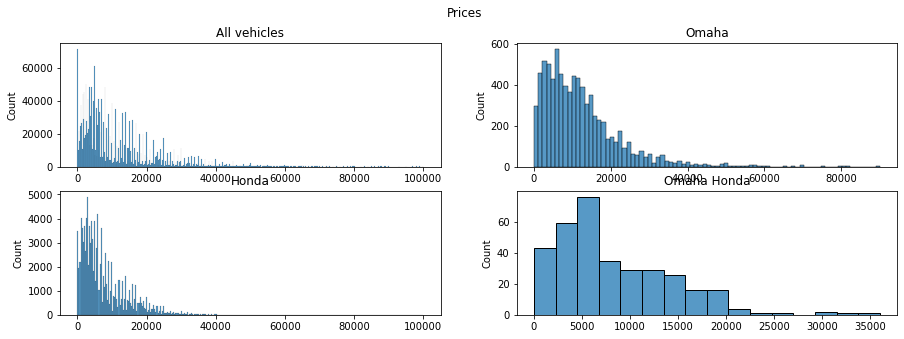

In [121]:
f = df.price.values
f = f[f < 100000]
g = omaha_df.price.values
g = g[g < 100000]
h = honda_df.price.values
h = h[h < 100000]
i = omahonda_df.price.values
i = i[i < 100000]

fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Prices')
sns.histplot(f, ax=axes[0,0])
axes[0,0].set_title('All vehicles')
sns.histplot(g, ax=axes[0,1])
axes[0,1].set_title('Omaha')
sns.histplot(h, ax=axes[1,0])
axes[1,0].set_title('Honda')
sns.histplot(i, ax=axes[1,1])
axes[1,1].set_title('Omaha Honda')

In [123]:
metrics = pd.DataFrame([np.mean(f),np.mean(g),np.mean(h),np.mean(i)], columns=['price'])

In [126]:
metrics['name'] = ['All vehicles','Omaha','Honda','Omaha Honda']

In [127]:
metrics

,price,name
0,11026.674149,All vehicles
1,11911.442456,Omaha
2,7439.562807,Honda
3,8375.141593,Omaha Honda


Text(0.5, 1.0, 'Omaha Honda')

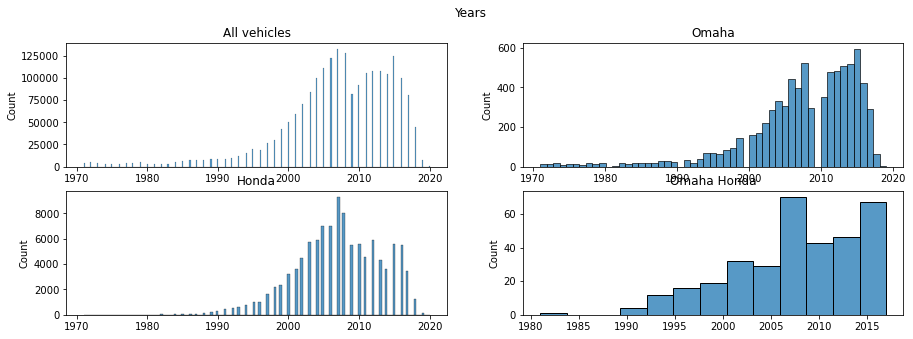

In [26]:
f = df.year.values
f = f[f > 1970]
g = omaha_df.year.values
g = g[g > 1970]
h = honda_df.year.values
h = h[h > 1970]
i = omahonda_df.year.values
i = i[i > 1970]

fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Years')
sns.histplot(f, ax=axes[0,0])
axes[0,0].set_title('All vehicles')
sns.histplot(g, ax=axes[0,1])
axes[0,1].set_title('Omaha')
sns.histplot(h, ax=axes[1,0])
axes[1,0].set_title('Honda')
sns.histplot(i, ax=axes[1,1])
axes[1,1].set_title('Omaha Honda')

In [131]:
metrics['year'] = [np.mean(f),np.mean(g),np.mean(h),np.mean(i)]
metrics.head()

,price,name,year
0,11026.674149,All vehicles,2006.927761
1,11911.442456,Omaha,2007.531707
2,7439.562807,Honda,2007.191988
3,8375.141593,Omaha Honda,2007.492625


Text(0.5, 1.0, 'Omaha Honda')

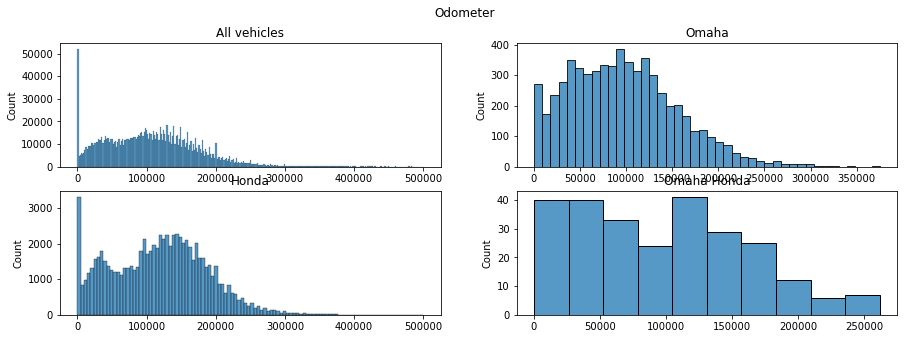

In [27]:
f = df.odometer.values
f = f[f < 500000]
g = omaha_df.odometer.values
g = g[g < 500000]
h = honda_df.odometer.values
h = h[h < 500000]
i = omahonda_df.odometer.values
i = i[i < 500000]

fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Odometer')
sns.histplot(f, ax=axes[0,0])
axes[0,0].set_title('All vehicles')
sns.histplot(g, ax=axes[0,1])
axes[0,1].set_title('Omaha')
sns.histplot(h, ax=axes[1,0])
axes[1,0].set_title('Honda')
sns.histplot(i, ax=axes[1,1])
axes[1,1].set_title('Omaha Honda')

In [135]:
metrics['odometer'] = [np.mean(f),np.mean(g),np.mean(h),np.mean(i)]
metrics.head()

,price,name,year,odometer
0,11026.674149,All vehicles,2006.927761,106702.774841
1,11911.442456,Omaha,2007.531707,96325.670002
2,7439.562807,Honda,2007.191988,118240.294098
3,8375.141593,Omaha Honda,2007.492625,97171.992218


In [ ]:
y = df.type
x = df.manufacturer

fig = go.Figure(go.Histogram2d(
        x=x,
        y=y
    ))
fig.show()

In [ ]:
y = omaha_df.type
x = omaha_df.manufacturer

fig = go.Figure(go.Histogram2d(
        x=x,
        y=y
    ))
fig.show()